# **Sometimes It’s Okay to Forget Stuff (Understanding Dropout in Neural Networks)**

---

When training a deep learning model, certain neurons can become overly influential. This creates a risk of **overfitting**, where the model performs extremely well during training but poorly during testing. In this situation, neurons in the next layer may rely too heavily on specific neurons from the previous layer instead of learning from *all* of them.

This is where **dropout** comes in.

### **What Is Dropout?**

In simple terms, **dropout randomly turns off some neurons during training**. Each training pass (epoch or batch) uses a slightly different version of the network because a different subset of neurons is active.

Think of it like flipping a coin for each neuron:

- Heads → keep the neuron
- Tails → drop it

If we set a dropout rate of 0.5, then every neuron has a **50% chance** of being disabled. That means for each forward pass, the network is essentially creating a new subnetwork.

**Mathematical view**

If $p$ is the dropout rate, then the probability a neuron gets dropped is:

$$P(\text{drop}) = p$$

And the probability a neuron stays active is:

$$P(\text{keep}) = 1 - p$$

When a neuron is dropped, its **incoming and outgoing connections are temporarily removed**, forcing the model to avoid reliance on any single neuron. This encourages all neurons to "work harder," improving the model’s robustness.

The downside? \
**Dropout slows learning**—the higher the dropout rate, the slower the convergence.

### **Dropout During Training vs. Inference**

A key detail: \
**Dropout is used only during training**, not during inference.

During testing or deployment, all neurons are active. But to make sure the output distribution matches what the model saw during training, we need to adjust the neuron weights.

A common method is **scaling the weights by the keep probability**:

$$\text{scaled weight} = (1 - p) \times \text{original weight}$$

This ensures that the expected output during inference matches the average output during training.

### **Inverted Dropout (The Modern Trick Everyone Uses)**

Most neural network libraries today use **inverted dropout**, which simplifies inference.

Here’s what happens:

1. During training, create a **dropout mask** \
    A mask $M$ has the same shape as the layer’s activations $A$:

    $$M_i \sim \text{Bernoulli}(1 - p)$$

    For each neuron:

    - $M_i = 1$ → keep neuron
    - $M_i = 0$ → drop neuron
      
    <br>

3. Apply dropout via element-wise multiplication:

    $$A' = A \odot M$$
   
4. **Scale the activations** by the keep probability:

    $$A'' = \frac{A'}{1 - p}$$

    This scaling ensures:

    $$\mathbb{E}[A''] = \mathbb{E}[A]$$

    Meaning the network behaves consistently whether dropout is used or not.
    
5. During inference? \
    **No dropout. No scaling. No randomness.** \
    The model becomes fully deterministic, which is exactly what we want.

### **Why Dropout Works (and How It’s Different from Other Regularization)**

Dropout forms **many tiny subnetworks**, each trained with slightly different active neurons. This is somewhat similar to training multiple decision trees in an ensemble.

Unlike other regularization techniques:

- **L2 regularization** penalizes large weights
- **Data augmentation** adds more samples
- **Batch normalization** stabilizes activations

Dropout, however, is **stochastic** and **probabilistic**, making it computationally simple while still very powerful.

Each subnetwork learns something slightly different, and together they create a strong, generalized model.

### **How to Use Dropout Correctly**

Here are the practical tips:

**✔ Choose an appropriate dropout rate**

- More complex networks → higher dropout
- Simpler networks → lower dropout

Typical values:

- **0.2–0.3** for convolutional layers
- **0.5** for fully-connected layers

**✔ Combine dropout with other regularization**

Dropout + L2 regularization is a powerful combo.

**✔ Use early stopping**

Stops training before overfitting kicks in—saving both time and compute.

### **PyTorch Dropout Demo on MNIST**

**1. Imports**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

**2. MNIST Dataset & DataLoaders**

In [2]:
%%capture
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

**3. Two Models — With & Without Dropout**

In [3]:
class MLP_NoDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
class MLP_Dropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.drop1 = nn.Dropout(p)
        self.fc2 = nn.Linear(256, 128)
        self.drop2 = nn.Dropout(p)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.drop1(self.fc1(x)))
        x = torch.relu(self.drop2(self.fc2(x)))
        return self.fc3(x)

**4. Helper Function — Train & Evaluate**

In [5]:
def train_and_eval(model, epochs=5):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    history = {"train_loss": [], "val_acc": []}
    start = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # validation accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        history["train_loss"].append(running_loss / len(train_loader))
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}: Loss={running_loss/len(train_loader):.4f}, Acc={val_acc:.2f}%")

    runtime = time.time() - start
    history["runtime"] = runtime

    return history

**5. Run Experiments**

In [6]:
no_dropout_model = MLP_NoDropout()
dropout_model = MLP_Dropout(p=0.5)

print("Training WITHOUT dropout...")
hist_no_drop = train_and_eval(no_dropout_model)

print("\nTraining WITH dropout...")
hist_drop = train_and_eval(dropout_model)

Training WITHOUT dropout...
Epoch 1: Loss=0.3414, Acc=95.10%
Epoch 2: Loss=0.1550, Acc=95.00%
Epoch 3: Loss=0.1131, Acc=96.63%
Epoch 4: Loss=0.0897, Acc=96.22%
Epoch 5: Loss=0.0770, Acc=97.25%

Training WITH dropout...
Epoch 1: Loss=0.6038, Acc=93.08%
Epoch 2: Loss=0.3622, Acc=94.32%
Epoch 3: Loss=0.3123, Acc=94.91%
Epoch 4: Loss=0.2938, Acc=95.39%
Epoch 5: Loss=0.2728, Acc=95.80%


**6. Visualization**

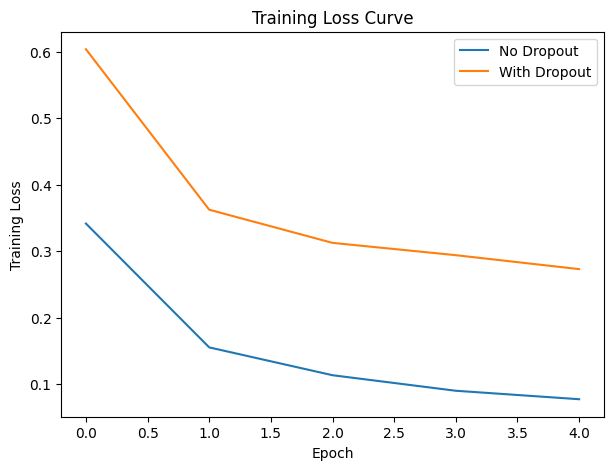

In [7]:
plt.figure(figsize=(7,5))
plt.plot(hist_no_drop["train_loss"], label="No Dropout")
plt.plot(hist_drop["train_loss"], label="With Dropout")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

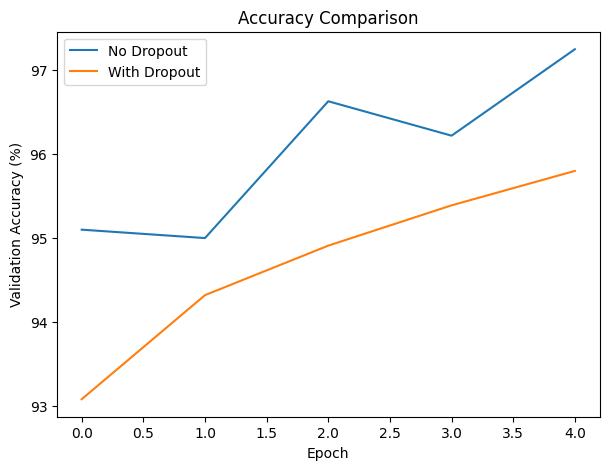

In [8]:
plt.figure(figsize=(7,5))
plt.plot(hist_no_drop["val_acc"], label="No Dropout")
plt.plot(hist_drop["val_acc"], label="With Dropout")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Accuracy Comparison")
plt.legend()
plt.show()

In [9]:
print(f"Runtime (No Dropout): {hist_no_drop['runtime']:.2f} sec")
print(f"Runtime (Dropout): {hist_drop['runtime']:.2f} sec")

Runtime (No Dropout): 59.99 sec
Runtime (Dropout): 59.06 sec


**7. Interpretation**

The model without dropout learned faster and achieved higher accuracy early, showing a steady drop in training loss and reaching 97.25% validation accuracy by Epoch 5. In contrast, the dropout model started with higher loss and slightly lower accuracy, but improved consistently and closed much of the gap, reflecting the slower but more stable learning that dropout encourages. While MNIST is simple enough that both models generalize well, the dropout version shows more controlled learning dynamics, reducing reliance on specific neurons and lowering overfitting risk. Runtime differences were negligible, indicating that dropout adds almost no computational overhead. Overall, the non-dropout model performs better in the short term, but the dropout model trends toward stronger generalization as training progresses.

### **In Summary**

Dropout teaches us an important lesson: \
**Sometimes it’s okay to forget things temporarily—because in the long run, it helps us perform better.**

By intentionally dropping neurons during training, we make our models more resilient, more balanced, and better at generalizing to new data.

**References**

- DataMListic. (2025). [*Dropout in Neural Networks - Explained*](https://youtu.be/FDF_Q3_98GQ?si=S0qXYkIU5WsNYuSx)
- Developers Hutt. (2023). [*Dropout layer in Neural Network | Dropout Explained | Quick Explained*](https://youtu.be/Fv8O4MvanJY?si=AaNE1AVpPeW-XsQg)
- Kashyap, P. (2024). [*Understanding Dropout in Deep Learning: A Guide to Reducing Overfitting*](https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575)